# Importing Dataset from Kaggle

In [1]:
import os
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akashsinghrajput","key":"af2c0604f55d265e7a67adf7f9255b28"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! kaggle datasets download -d salmaneunus/railway-track-fault-detection

 99% 1.98G/2.00G [00:17<00:00, 102MB/s] 
100% 2.00G/2.00G [00:18<00:00, 119MB/s]


In [5]:
! unzip /content/railway-track-fault-detection.zip -d /content/

Archive:  /content/railway-track-fault-detection.zip
  inflating: /content/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_100159.jpg  
  inflating: /content/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_100209.jpg  
  inflating: /content/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_101124.jpg  
  inflating: /content/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_101200.jpg  
  inflating: /content/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_102203.jpg  
  inflating: /content/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_102222.jpg  
  inflating: /content/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_102819.jpg  
  inflating: /content/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_103110.jpg  
  inflating: /content/Railway Track fault Detection Updated/Test/Defective/IMG_20201211_121712.jpg  
  inflating: /content/Railway Track fa

In [6]:
os.rename('/content/Railway Track fault Detection Updated/', '/content/Railway')

# Code Section

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.metrics import classification_report

mpl.rcParams['figure.dpi'] = 100

# Image Visualization

In [8]:
image_size = (224, 224)

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/Railway/Train',
  seed=123,
  image_size=image_size,
  batch_size=32)

Found 299 files belonging to 2 classes.


In [10]:
class_names = train_ds.class_names

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

# Image Preprocessing and Augmentation

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip = True,
    vertical_flip = True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [12]:
train_data = train_datagen.flow_from_directory('/content/Railway/Train', 
                                               target_size=image_size, 
                                               batch_size=32, 
                                               class_mode='binary')

val_data = val_datagen.flow_from_directory('/content/Railway/Validation', 
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='binary')


test_data = test_datagen.flow_from_directory('/content/Railway/Test', 
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='binary')

Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


# Transfer Learing


In [13]:
def url_to_model(model_url, image_size, hidden_layers, fine_tunable) :
  feature_vector = [hub.KerasLayer(model_url, trainable=fine_tunable)]
  sequential_list = feature_vector + hidden_layers

  model = tf.keras.Sequential(sequential_list)
  
  model.build([None, image_size[0], image_size[1], 3])
  
  model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

  return model

In [14]:
class Callback(tf.keras.callbacks.Callback) :
  def on_train_begin(self, logs=None):
    print("Callback working!")

  def on_epoch_end(self, epoch, logs=None):
        if(epoch%5==0):
          self.model.save(f'/content/drive/MyDrive/models/MobileNet/Fine_Tunable/epoch_{epoch}')

In [15]:
hidden_layers = [
    layers.Dropout(0.2),
    layers.Dense(64, 
                 kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001),
                 bias_regularizer=tf.keras.regularizers.L2(1e-4),
                 activity_regularizer=tf.keras.regularizers.L2(1e-5),
                 activation='relu'),
    layers.Dense(32, 
                 kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01),
                 bias_regularizer=tf.keras.regularizers.L2(1e-4),
                 activity_regularizer=tf.keras.regularizers.L2(1e-5),
                 activation='relu'),
    layers.Dense(1, activation='sigmoid'),
]

In [16]:
mobileNet = url_to_model("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5", 
                        image_size,
                        hidden_layers, 
                        fine_tunable = False
                        )

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
mobileNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,310,529
Trainable params: 84,097
Non-trainable params: 4,226,432
_________________________________________________________________


In [18]:
mobileNetHistory = mobileNet.fit(train_data, validation_data=val_data, epochs=50, callbacks=[Callback()])

Callback working!
Epoch 1/50
10/10 [==============================] - 115s 10s/step - loss: 3.8786 - accuracy: 0.5686 - val_loss: 3.7334 - val_accuracy: 0.5968
Epoch 2/50
10/10 [==============================] - 86s 9s/step - loss: 3.5388 - accuracy: 0.6990 - val_loss: 3.4437 - val_accuracy: 0.6613
Epoch 3/50
10/10 [==============================] - 85s 9s/step - loss: 3.2886 - accuracy: 0.7559 - val_loss: 3.2045 - val_accuracy: 0.7581
Epoch 4/50
10/10 [==============================] - 86s 9s/step - loss: 3.0688 - accuracy: 0.7960 - val_loss: 3.0060 - val_accuracy: 0.7742
Epoch 5/50
10/10 [==============================] - 85s 9s/step - loss: 2.8731 - accuracy: 0.8227 - val_loss: 2.8227 - val_accuracy: 0.7903
Epoch 6/50
10/10 [==============================] - 95s 10s/step - loss: 2.6715 - accuracy: 0.8227 - val_loss: 2.6621 - val_accuracy: 0.7742
Epoch 7/50
10/10 [==============================] - 85s 9s/step - loss: 2.4959 - accuracy: 0.8361 - val_loss: 2.5238 - val_accuracy: 0.7742

In [24]:
mobileNet.save('/content/drive/MyDrive/model')

In [25]:
import joblib

joblib.dump(mobileNetHistory.history, '/content/drive/MyDrive/model/history.sav')

['/content/drive/MyDrive/model/history.sav']

In [26]:
x_epochs = np.arange(50)

### Model History

In [30]:
from google.colab import drive
drive.mount('/content/drive/model')

Mounted at /content/drive/model


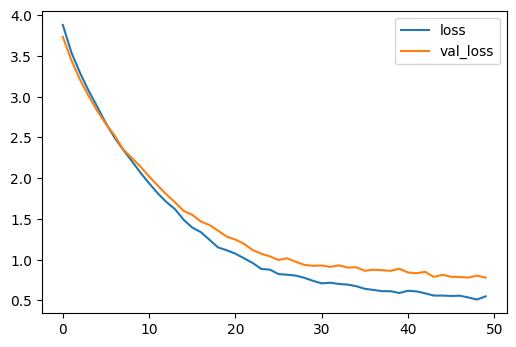

In [31]:
plt.plot(x_epochs, mobileNetHistory.history['loss'], label='loss')
plt.plot(x_epochs, mobileNetHistory.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

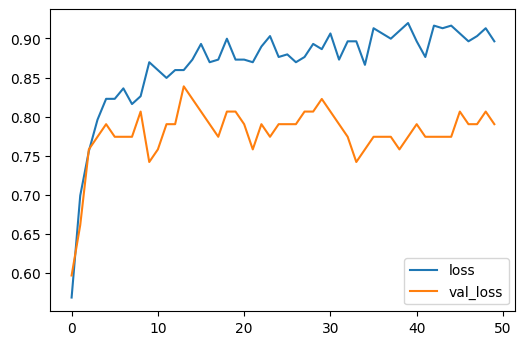

In [32]:
plt.plot(x_epochs, mobileNetHistory.history['accuracy'], label='loss')
plt.plot(x_epochs, mobileNetHistory.history['val_accuracy'], label='val_loss')
plt.legend()
plt.show()

### Model Evaluation

In [33]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)


test_data = test_datagen.flow_from_directory('/content/Railway/Train', 
                                            target_size=image_size,
                                            batch_size=1,
                                            class_mode='binary')

Found 299 images belonging to 2 classes.


### Classification Report